In [52]:
from __future__ import division
import numpy as np
import scipy as sp
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt


In [6]:
covid_url = 'https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/resource/926fd08f-cc91-4828-af38-bd45de97f8c3/download/statewide_cases.csv'

In [7]:
s=requests.get(covid_url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [45]:
all_fields = c.columns
all_fields

Index(['county', 'totalcountconfirmed', 'totalcountdeaths',
       'newcountconfirmed', 'newcountdeaths', 'date'],
      dtype='object')

In [92]:
dates = np.unique(c['date'])
all_counties = np.unique(c['county'])
dates[0]

'2020-03-18'

In [54]:
counties_south = np.array(['Imperial',
                           'Kern',
                           'Los Angeles',
                           'Orange',
                           'Riverside',
                           'San Bernardino',
                           'San Diego',
                           'Santa Barbara',
                           'San Luis Obispo',
                           'Ventura'])
counties_north = np.array([ct for ct in all_counties if ct not in counties_south])

In [37]:
#Check that stats are accurate - compute new case count for a given day
date_to_run = dates[-1]
np.sum(c['newcountconfirmed'][c['date'] == date_to_run])

4176

In [78]:
def compute_MA_Given_Dates(df,dtr):
    curr_cases = 0
    for dt in dtr:
        curr_cases += np.sum(df['newcountconfirmed'][df['date'] == dt])
    return curr_cases/len(dtr)

In [79]:
#Compute moving average over the last N-days available in the database
#Do so for all california, and contrast north vs south
n_MA = 3 #Order of the moving average
dates_to_run = dates[-n_MA:]
cases_full_cali = compute_MA_Given_Dates(c,dates_to_run)

#Prune data frame into counties north and south
c_south = c.copy()
c_south = c_south.drop(np.where(np.isin(c['county'],counties_north))[0])
c_north = c.copy()
c_north = c_north.drop(np.where(np.isin(c['county'],counties_south))[0])

#Compute N-day MA for north and south as well
dates_to_run = dates[-n_MA:]
cases_north_cali = compute_MA_Given_Dates(c_north,dates_to_run)
cases_south_cali = compute_MA_Given_Dates(c_south,dates_to_run)

In [82]:
print(str(n_MA)+'-Day MA for Cases on: ' + dates_to_run[-1])
print('All California: ' + "{:.2f}".format(cases_full_cali) + ' new cases/day')
print('NorCal: ' + "{:.2f}".format(cases_north_cali) + ' new cases/day')
print('SoCal: ' + "{:.2f}".format(cases_south_cali) + ' new cases/day')

3-Day MA for Cases on: 2020-08-30
All California: 5075.67 new cases/day
NorCal: 2374.67 new cases/day
SoCal: 2701.00 new cases/day


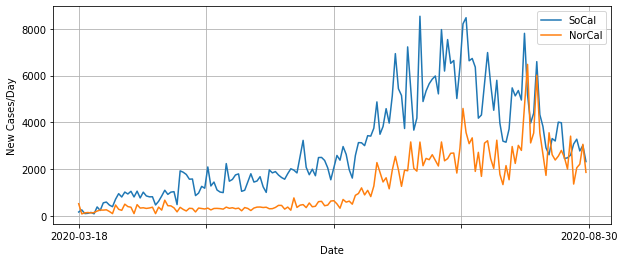

In [101]:
#Need to apply Lauren's 25% of peak heuristic to south county
#First compute daily average across all
allRate_SoCal = np.zeros((len(dates),1))
allRate_NorCal = np.zeros((len(dates),1))
for i_dt in range(len(dates)):
    allRate_SoCal[i_dt] = np.sum(c_south['newcountconfirmed'][c_south['date'] == dates[i_dt]])
    allRate_NorCal[i_dt] = np.sum(c_north['newcountconfirmed'][c_north['date'] == dates[i_dt]])
plt.figure(figsize = (10,4))
plt.plot(allRate_SoCal)
plt.plot(allRate_NorCal)
plt.xlabel('Date')
plt.ylabel('New Cases/Day')
plt.xticks([0,len(dates)*0.25,len(dates)*0.5,len(dates)*0.75,len(dates)],(dates[0],'','','',dates[-1]))
plt.legend(['SoCal','NorCal'])
plt.grid()

In [110]:
#Next compute peak rate and find Lauren's 25% threshold for SoCal:
drop_threshold = 0.25*np.max(allRate_SoCal)

print('Do we initiate drop sequence on: ' + dates_to_run[-1])
print('Current SoCal Rate: ' + "{:.2f}".format(cases_south_cali) + ' new cases/day')
print('Threshold for drop sequence init: '+ "{:.2f}".format(drop_threshold) + ' new cases/day')
if(cases_south_cali < drop_threshold):
    print('COMMENCE DROP SEQUENCE')
else:
    print('STANDBY FOR FURTHER GUIDANCE')

Do we initiate drop sequence on: 2020-08-30
Current SoCal Rate: 2701.00 new cases/day
Threshold for drop sequence init: 2134.75 new cases/day
STANDBY FOR FURTHER GUIDANCE
